In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TWITTER PLATFORMUNDA GERÇEK-SAHTE HABER TESPİTİ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from os import path
import os
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import re
import string

from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models import Word2Vec 
from gensim.models import FastText
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import plot_confusion_matrix

import keras
from keras import optimizers
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional,Flatten
from keras.layers.embeddings import Embedding

import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Veri İnceleme

In [ ]:
df = pd.read_csv("drive/MyDrive/pheme.csv")

In [ ]:
df.head()

,ID,Event,Text,Rumour
0,552784600502915072,charliehebdo-all-rnr-threads,Charlie Hebdo became well known for publishing...,nonrumour
1,552784898743099392,charliehebdo-all-rnr-threads,Charlie Hebdo’s Last Tweet Before Shootings ht...,nonrumour
2,552785391653494784,charliehebdo-all-rnr-threads,Prediction: the #CharlieHebdo massacre will no...,nonrumour
3,552786116404072448,charliehebdo-all-rnr-threads,10:28am Charlie Hebdo account mocks ISIS leade...,nonrumour
4,552786299875520512,charliehebdo-all-rnr-threads,If your faith isn't strong enough to cope with...,nonrumour


In [ ]:
df.shape

(6425, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6425 non-null   int64 
 1   Event   6425 non-null   object
 2   Text    6425 non-null   object
 3   Rumour  6425 non-null   object
dtypes: int64(1), object(3)
memory usage: 200.9+ KB


In [ ]:
df["Event"].value_counts()

charliehebdo-all-rnr-threads         2079
sydneysiege-all-rnr-threads          1221
ferguson-all-rnr-threads             1143
ottawashooting-all-rnr-threads        890
germanwings-crash-all-rnr-threads     469
putinmissing-all-rnr-threads          238
prince-toronto-all-rnr-threads        233
gurlitt-all-rnr-threads               138
ebola-essien-all-rnr-threads           14
Name: Event, dtype: int64

In [ ]:
mapping = {"charliehebdo-all-rnr-threads":"Charlie Hebdo",
           "sydneysiege-all-rnr-threads":"Sydney Siege", 
           "ferguson-all-rnr-threads":"Ferguson",
           "ottawashooting-all-rnr-threads":"Ottawa Shooting",
           "germanwings-crash-all-rnr-threads":"Germanwings Crash",
           "putinmissing-all-rnr-threads":"Putin Missing",
           "prince-toronto-all-rnr-threads":"Prince Toronto",
           "gurlitt-all-rnr-threads":"Gurlitt",
           "ebola-essien-all-rnr-threads":"Ebola Essien"}

df["Event"]=df["Event"].replace(mapping)

In [ ]:
df["Event"].value_counts()

Charlie Hebdo        2079
Sydney Siege         1221
Ferguson             1143
Ottawa Shooting       890
Germanwings Crash     469
Putin Missing         238
Prince Toronto        233
Gurlitt               138
Ebola Essien           14
Name: Event, dtype: int64

## Olayların Görselleştirilmesi

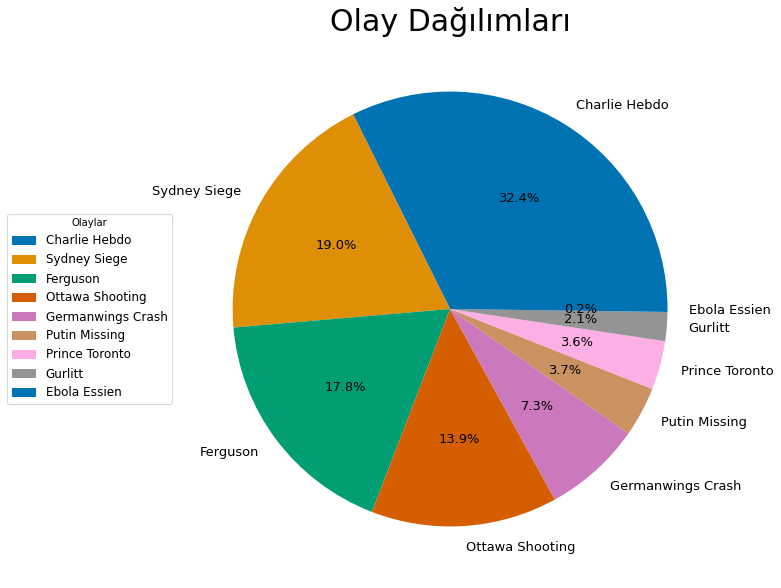

In [ ]:
values = df["Event"].value_counts().values
labels = df["Event"].value_counts().index
plt.figure(figsize=[10,10])
colors = sns.color_palette('colorblind')[0:8]
plt.pie(values,labels=labels,colors = colors, autopct='%1.1f%%',textprops={'fontsize': 13})

plt.title("Olay Dağılımları",fontdict = {'fontsize' : 30})
plt.legend(title = "Olaylar",
           loc = "center right",
           bbox_to_anchor = (0, 0.5, 0, 0),
           fontsize=12)
plt.show()

Text(0, 0.5, 'Olaylar')

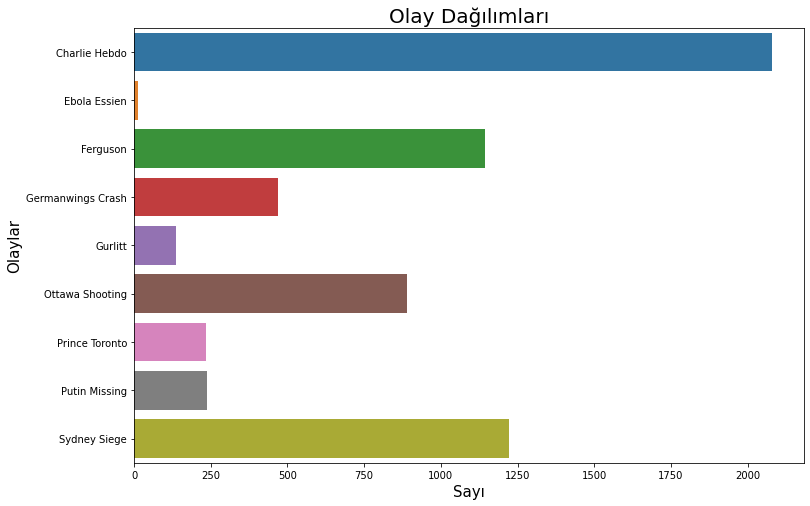

In [ ]:
plt.figure(figsize=[12,8])
sns.countplot(data=df,y='Event')
plt.title("Olay Dağılımları",fontsize=20)
plt.xlabel("Sayı",fontsize=15)
plt.ylabel("Olaylar",fontsize=15)

## Sahte Gerçek Haberlerin Görselleştirilmesi

In [ ]:
mapping = {"nonrumour":"Gerçek",
           "rumour":"Sahte", 
           "unclear":"Belirsiz"}

df["Rumour"]=df["Rumour"].replace(mapping)
df["Rumour"].value_counts()

Gerçek      4022
Sahte       2402
Belirsiz       1
Name: Rumour, dtype: int64

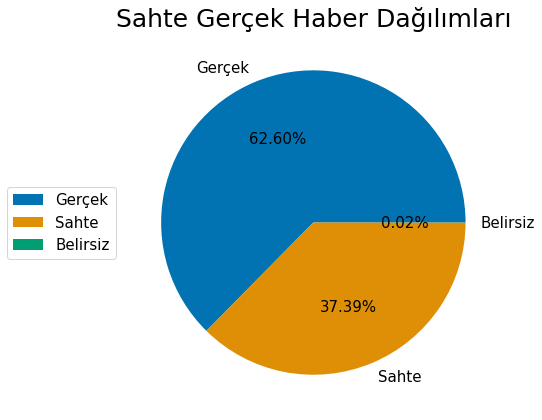

In [ ]:
values = df["Rumour"].value_counts().values
labels = df["Rumour"].value_counts().index
plt.figure(figsize=[7,7])
plt.pie(values,labels=labels,colors = colors, autopct='%1.2f%%',textprops={'fontsize': 15})

plt.title("Sahte Gerçek Haber Dağılımları",fontdict = {'fontsize' : 25})
plt.legend(loc = "center right",
           bbox_to_anchor = (0, 0.5, 0, 0),
           fontsize=15)
plt.show()

Text(0, 0.5, 'Olaylar')

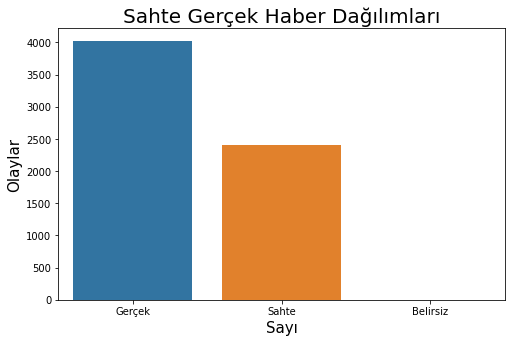

In [ ]:
plt.figure(figsize=[8,5])
sns.countplot(data=df,x='Rumour')
plt.title("Sahte Gerçek Haber Dağılımları",fontsize=20)
plt.xlabel("Sayı",fontsize=15)
plt.ylabel("Olaylar",fontsize=15)

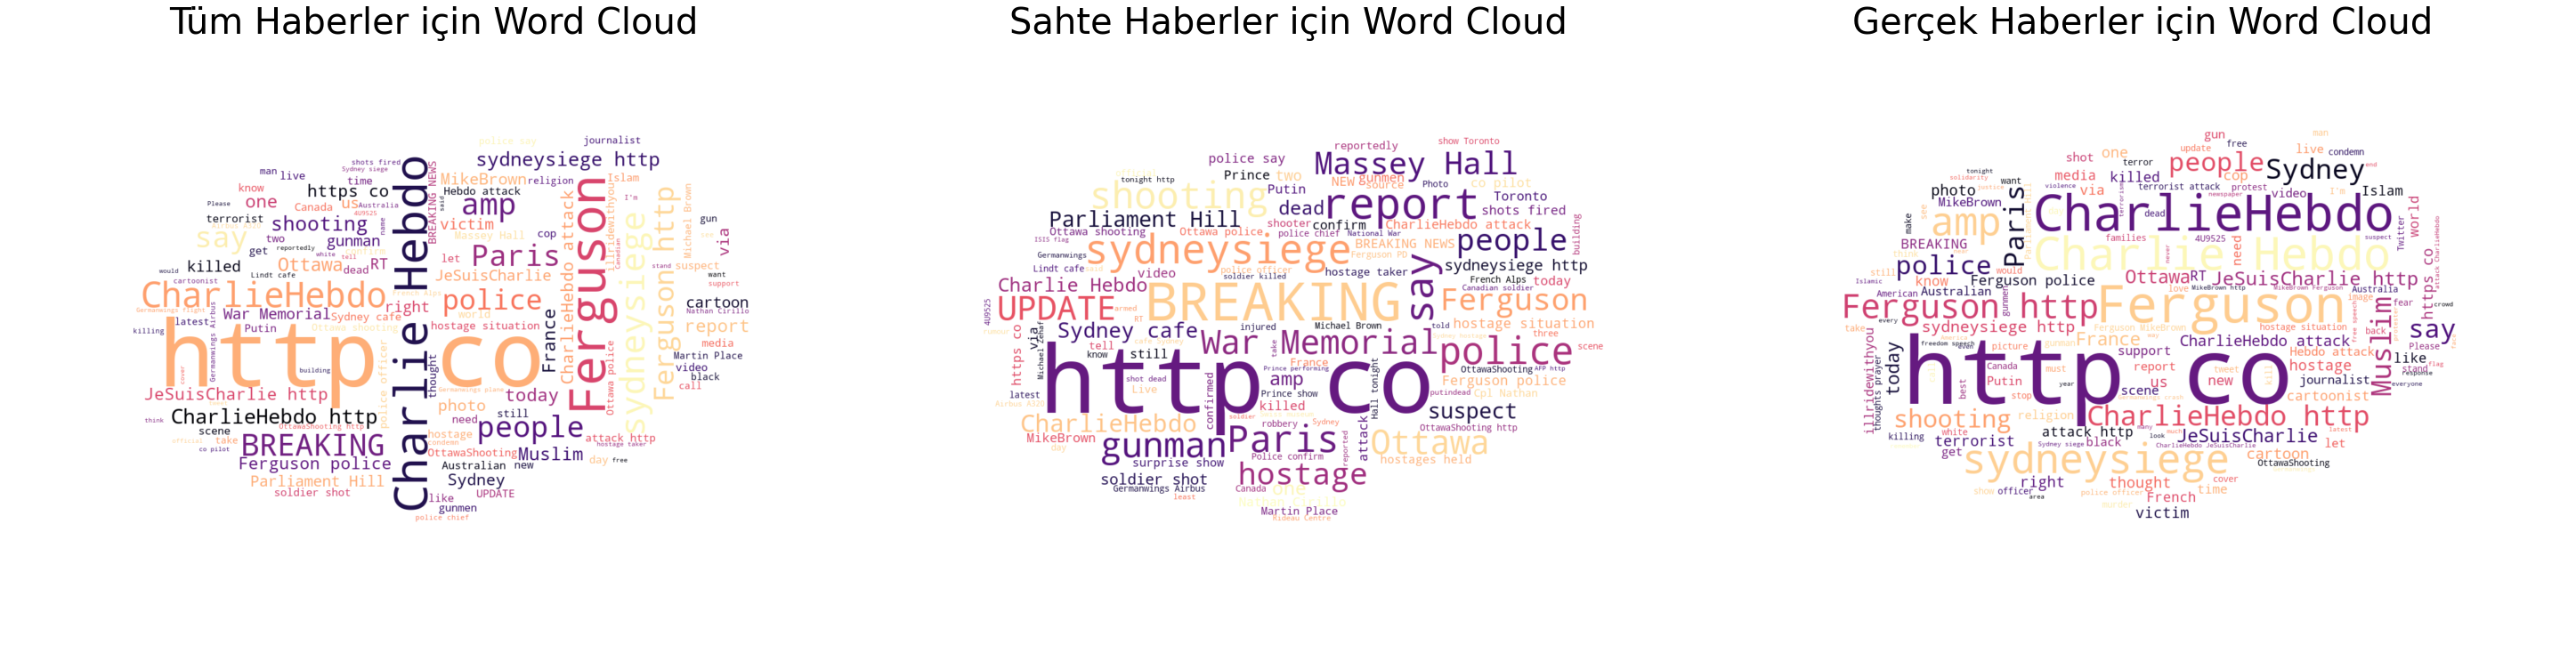

In [ ]:
gercek = df[df["Rumour"]=="Gerçek"]
sahte = df[df["Rumour"]=="Sahte"]
l = [df,sahte,gercek]
titles = ["Tüm Haberler için Word Cloud",
          "Sahte Haberler için Word Cloud",
          "Gerçek Haberler için Word Cloud"]

fig = plt.figure(figsize = (40,60),
                  facecolor = 'None',
                  edgecolor = 'k')
for i in range(3):
  text = ''
  for haber in l[i].Text.values:
      text += f" {haber}"

  d = path.dirname("drive/MyDrive/")
  mask = np.array(Image.open(path.join(d, "cloud.png")))
  stopword = set(nltk.corpus.stopwords.words("english"))

  wordcloud = WordCloud(
      width = 400,
      height = 400,
      background_color = 'white',
      mask=mask,
      min_font_size = 10,
      colormap="magma",
      random_state=0,
      stopwords = stopword).generate(str(text))

  plt.subplot(1,3,i+1)
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title(titles[i],fontsize=40)
  plt.axis('off')
  plt.tight_layout(pad=0)
plt.show()
del text

## Olayların Haber Türüne Göre Görselleştirilmesi

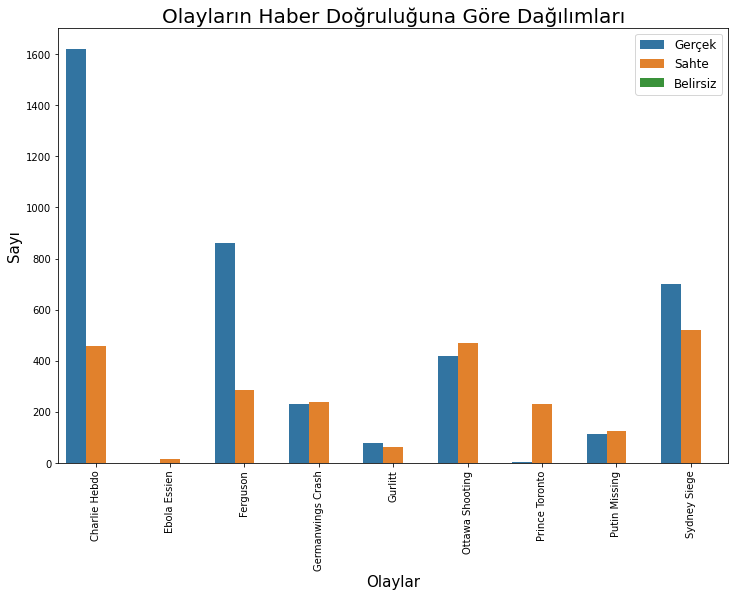

In [ ]:
plt.figure(figsize=[12,8])
sns.countplot(x="Event",hue="Rumour", data=df)
plt.legend(loc='upper right',fontsize=12)
plt.title("Olayların Haber Doğruluğuna Göre Dağılımları",fontsize=20)
plt.xticks(rotation=90)
plt.ylabel("Sayı",fontsize=15)
plt.xlabel("Olaylar",fontsize=15)
plt.show()

# Veri Önişleme 

In [ ]:
#null değer olan unclear siliniyor

df.drop(df[df["Rumour"] == "Belirsiz"].index,axis=0,inplace=True)

In [ ]:
df.drop(["ID","Event"],axis=1,inplace=True)

In [ ]:
df.shape

(6424, 2)

In [ ]:
df.head()

,Text,Rumour
0,Charlie Hebdo became well known for publishing...,Gerçek
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,Gerçek
2,Prediction: the #CharlieHebdo massacre will no...,Gerçek
3,10:28am Charlie Hebdo account mocks ISIS leade...,Gerçek
4,If your faith isn't strong enough to cope with...,Gerçek


In [ ]:
le = LabelEncoder()
df.Rumour = le.fit_transform(df.Rumour)

In [ ]:
df.head()

,Text,Rumour
0,Charlie Hebdo became well known for publishing...,0
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,0
2,Prediction: the #CharlieHebdo massacre will no...,0
3,10:28am Charlie Hebdo account mocks ISIS leade...,0
4,If your faith isn't strong enough to cope with...,0


## Nokatalama İşaretleri

In [ ]:
#noktalama kaldırma
noktalamasiz= []
for i in df.Text:
  son = ""
  for j in i:
    if j not in string.punctuation:
      son += j
  noktalamasiz.append(son)
df["Temiz"] = noktalamasiz

df.head(5)

,Text,Rumour,Temiz
0,Charlie Hebdo became well known for publishing...,0,Charlie Hebdo became well known for publishing...
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,0,Charlie Hebdo’s Last Tweet Before Shootings ht...
2,Prediction: the #CharlieHebdo massacre will no...,0,Prediction the CharlieHebdo massacre will not ...
3,10:28am Charlie Hebdo account mocks ISIS leade...,0,1028am Charlie Hebdo account mocks ISIS leader...
4,If your faith isn't strong enough to cope with...,0,If your faith isnt strong enough to cope with ...


## Büyük Küçük Harfler

In [ ]:
#büyük harfleri küçük harfe dönüştürme ve tokenize
kucukHarfveTokenize=[]
for text in df.Temiz:
  text=text.lower()
  text=text.split()
  kucukHarfveTokenize.append(text)

df["Temiz"] = kucukHarfveTokenize
df.head()

,Text,Rumour,Temiz
0,Charlie Hebdo became well known for publishing...,0,"[charlie, hebdo, became, well, known, for, pub..."
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,0,"[charlie, hebdo’s, last, tweet, before, shooti..."
2,Prediction: the #CharlieHebdo massacre will no...,0,"[prediction, the, charliehebdo, massacre, will..."
3,10:28am Charlie Hebdo account mocks ISIS leade...,0,"[1028am, charlie, hebdo, account, mocks, isis,..."
4,If your faith isn't strong enough to cope with...,0,"[if, your, faith, isnt, strong, enough, to, co..."


## Etkisiz Kelimeler

In [ ]:
#stopword kaldırma
stopwords = nltk.corpus.stopwords.words('english')

stopwordsuz= []
for text in df.Temiz:
  son =[]
  for i in text:
    if i not in stopwords:
      son.append(i)
  stopwordsuz.append(son)
df["Temiz"] = stopwordsuz
df.head()

,Text,Rumour,Temiz
0,Charlie Hebdo became well known for publishing...,0,"[charlie, hebdo, became, well, known, publishi..."
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,0,"[charlie, hebdo’s, last, tweet, shootings, htt..."
2,Prediction: the #CharlieHebdo massacre will no...,0,"[prediction, charliehebdo, massacre, dent, pol..."
3,10:28am Charlie Hebdo account mocks ISIS leade...,0,"[1028am, charlie, hebdo, account, mocks, isis,..."
4,If your faith isn't strong enough to cope with...,0,"[faith, isnt, strong, enough, cope, satirical,..."


## Linkler

In [ ]:
#http ile başlayan linkleri kaldırma
tweets = list()

for tweet in df.Temiz:
    cümle = list()
    for kelime in tweet:
        if not kelime.startswith("http"):
            cümle.append(kelime)
    tweets.append(cümle)
df.Temiz = tweets

## Stemming

In [ ]:
snow_stemmer = SnowballStemmer(language='english')
stemmed=[]
for text in df.Temiz:
  son = []
  for i in text:
    son.append(snow_stemmer.stem(i))
  stemmed.append(" ".join(son)) 
df["Stemmed"] = stemmed
df.head()

,Text,Rumour,Temiz,Stemmed
0,Charlie Hebdo became well known for publishing...,0,"[charlie, hebdo, became, well, known, publishi...",charli hebdo becam well known publish muham ca...
1,Charlie Hebdo’s Last Tweet Before Shootings ht...,0,"[charlie, hebdo’s, last, tweet, shootings]",charli hebdo last tweet shoot
2,Prediction: the #CharlieHebdo massacre will no...,0,"[prediction, charliehebdo, massacre, dent, pol...",predict charliehebdo massacr dent polit classs...
3,10:28am Charlie Hebdo account mocks ISIS leade...,0,"[1028am, charlie, hebdo, account, mocks, isis,...",1028am charli hebdo account mock isi leader wi...
4,If your faith isn't strong enough to cope with...,0,"[faith, isnt, strong, enough, cope, satirical,...",faith isnt strong enough cope satir poke ought...


In [ ]:
df.tail()

,Text,Rumour,Temiz,Stemmed
6420,Police confirm that #sydneysiege is finally ov...,1,"[police, confirm, sydneysiege, finally, two, p...",polic confirm sydneysieg final two peopl repor...
6421,"Sad end: 2 people are dead, 3 in serious condi...",1,"[sad, end, 2, people, dead, 3, serious, condit...",sad end 2 peopl dead 3 serious condit hostag s...
6422,Seven people reportedly taken away on stretche...,1,"[seven, people, reportedly, taken, away, stret...",seven peopl report taken away stretcher parame...
6423,BREAKING: CNN: Sydney police storm cafe. 2 con...,1,"[breaking, cnn, sydney, police, storm, cafe, 2...",break cnn sydney polic storm cafe 2 confirm de...
6424,"Sadly, at this stage, there are two confirmed ...",1,"[sadly, stage, two, confirmed, deaths, describ...",sad stage two confirm death describ cardiac ar...


In [ ]:
df.to_csv('stemmed.csv')

## Word2Vec

In [ ]:
y=df['Rumour'].values
X=[d.split() for d in df['Stemmed']]

In [ ]:
X[1]

['charli', 'hebdo', 'last', 'tweet', 'shoot']

In [ ]:
DIM=100
model_w2v=Word2Vec(sentences=X, size=DIM, window=10, min_count=1)
model_w2v.wv.most_similar('charli')

[('attack', 0.9997546672821045),
 ('satir', 0.9996780157089233),
 ('magazin', 0.9996398687362671),
 ('newspap', 0.9996066093444824),
 ('week', 0.9995312690734863),
 ('gunmen', 0.9995266795158386),
 ('publish', 0.9995017051696777),
 ('terrorist', 0.9994914531707764),
 ('dead', 0.9994772672653198),
 ('→', 0.9994396567344666)]

In [ ]:
model_w2v_sg=Word2Vec(sentences=X, size=DIM, window=10, min_count=1,sg = 1)
model_w2v_sg.wv.most_similar('charli')

[('satir', 0.9592087268829346),
 ('week', 0.9541387557983398),
 ('magazin', 0.9531518220901489),
 ('newspap', 0.9425513744354248),
 ('publish', 0.9165229797363281),
 ('attack', 0.9161028861999512),
 ('hebdo', 0.9095839262008667),
 ('→', 0.8927892446517944),
 ('headquart', 0.8856765031814575),
 ('charliehebdo', 0.880675733089447)]

In [ ]:
X[1]

['charli', 'hebdo', 'last', 'tweet', 'shoot']

In [ ]:
len(model_w2v.wv.vocab)

6932

In [ ]:
model_w2v.wv['charli']

array([-0.5887632 ,  0.6990209 , -0.35065633, -0.26947272,  0.26284108,
        0.4131993 , -0.59542125, -0.41339898, -0.02392677, -0.78550506,
        0.03704271, -0.7619221 , -0.12917161,  1.0838113 ,  0.8144802 ,
        0.7678835 ,  0.30912036,  0.65379906,  0.03168875,  0.80875176,
       -1.0182928 , -0.52438986,  0.42979005, -0.02818385,  0.8945829 ,
        0.5519094 , -1.0440431 ,  0.42777538,  0.17045413,  0.53924894,
        0.28167757,  0.9939141 , -0.4682981 ,  0.40582103, -0.850645  ,
       -0.37605956,  1.2848088 ,  0.29339242, -0.09331165, -0.41815022,
       -0.3059101 , -0.10346798, -0.51827437,  0.58693683,  0.52748847,
        1.1735835 , -0.38723788, -0.48185572, -0.9900149 ,  0.21428534,
       -0.6024368 , -0.9525678 , -0.5109219 , -0.33065334,  0.3710822 ,
        0.3226301 ,  0.35692382, -0.88494456, -1.2854548 , -0.32421312,
       -0.14383262, -0.28591344, -0.6699624 ,  0.43339476, -0.06808601,
       -0.3908713 ,  0.425386  ,  0.53557295,  0.49360698,  0.86

In [ ]:
model_w2v.wv.most_similar('charli')

[('attack', 0.9997546672821045),
 ('satir', 0.9996780157089233),
 ('magazin', 0.9996398687362671),
 ('newspap', 0.9996066093444824),
 ('week', 0.9995312690734863),
 ('gunmen', 0.9995266795158386),
 ('publish', 0.9995017051696777),
 ('terrorist', 0.9994914531707764),
 ('dead', 0.9994772672653198),
 ('→', 0.9994396567344666)]

## FastText

In [ ]:
model_fast_sg = FastText(sentences=X, size=DIM, window=5, min_count=1, sg=1)
model_fast_sg.most_similar('charli')

[('charli…', 0.9969363212585449),
 ('iamcharli', 0.9919010996818542),
 ('charlie”', 0.990353524684906),
 ('charl', 0.9889603853225708),
 ('excharli', 0.9836817979812622),
 ('charlyhebdo', 0.9815018773078918),
 ('carli', 0.9788562655448914),
 ('charliehebd', 0.9781463146209717),
 ('charliehebdo', 0.9779576659202576),
 ('charliehebdu', 0.9777215719223022)]

In [ ]:
model_fast = FastText(sentences=X, size=DIM, window=5, min_count=1, sg=0)
model_fast.most_similar('charli')

[('charli…', 0.9999901056289673),
 ('iamcharli', 0.9999799728393555),
 ('charl', 0.9999758005142212),
 ('charlie”', 0.9999745488166809),
 ('excharli', 0.999957799911499),
 ('charliehedbo', 0.9999459385871887),
 ('charliehebdu', 0.9999397397041321),
 ('charliehebd', 0.9999388456344604),
 ('charliehebdoitl', 0.9999268054962158),
 ('charliehebdo', 0.9999200105667114)]

In [ ]:
y=df['Rumour']
X=df["Stemmed"]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5139,)
(5139,)
(1285,)
(1285,)


In [ ]:
y_test

3373    0
4887    1
4131    0
1159    0
2247    0
       ..
367     0
804     0
4073    0
4816    1
4018    0
Name: Rumour, Length: 1285, dtype: int64

In [ ]:
y_test[4887]          #4887 , 4816

1

In [ ]:
x_test[4887]

'contrari popular belief liven state secret princ show massey hall'

In [ ]:
y_test[4816]

1

In [ ]:
x_test[4816]

'line princ rumour show toronto'

In [ ]:
x_train = x_train.values
x_test = x_test.values

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X[6422]

'seven peopl report taken away stretcher paramed treat five sydneysieg'

In [ ]:
X=tokenizer.texts_to_sequences(X)

In [ ]:
X[6422]

[12, 385, 6, 3, 189, 25, 58, 41, 38, 6931, 40, 24, 1075]

In [ ]:
vocab = tokenizer.word_index

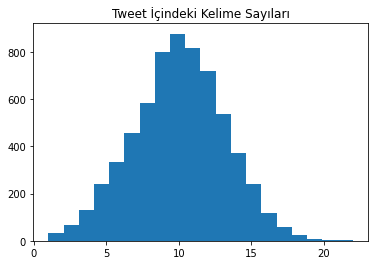

In [ ]:
plt.hist([len(x) for x in X], bins=20)
plt.title("Tweet İçindeki Kelime Sayıları")
plt.show()

In [ ]:
def max_len(X):
  max = 0
  for i in X:
    if len(i)>max:
        max=len(i)
  return max

In [ ]:
maxlen=max_len(X)
X=pad_sequences(X, padding="post",maxlen=maxlen)

In [ ]:
X[6422]

array([  12,  385,    6,    3,  189,   25,   58,   41,   38, 6931,   40,
         24, 1075,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
vocab_size=len(tokenizer.word_index)+1 
vocab_size

6933

In [ ]:
def matrix(model):
    weight_matrix = np.zeros((10000,DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word] 

    return weight_matrix

In [ ]:
embedding_vectors_w2v = matrix(model_w2v)
embedding_vectors_fast = matrix(model_fast)

In [ ]:
print(embedding_vectors_w2v.shape)
print(embedding_vectors_fast.shape)

(10000, 100)
(10000, 100)


In [ ]:
scores = list()
def model_history(model,name):
  y_pred = (model.predict(x_test) >= 0.5).astype("int")
  print("--------------------Accuracy Score----------------------")
  val_acc = accuracy_score(y_test,y_pred)
  print(val_acc)
  print("\n----------------Classification Report ------------------")
  print(classification_report(y_test,y_pred))
  loss, accuracy= model.evaluate(x_train,y_train,verbose=0)
  print("\n------------Training Loss Accuracy----------------------")
  print("Training Loss:",loss)
  print("Training Accuracy:",accuracy)
  cf = confusion_matrix(y_test,y_pred)
  print("\n-------------------Confusion Matrix---------------------")
  sns.heatmap(cf, annot=True,fmt="")
  plt.show()
  scores.append([name,round(accuracy,3),round(loss,3),round(val_acc,3)])
  model.save(name+".h5")
  print("Saved model to disk")

In [ ]:
traning_acc = list()
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc,'rs--', label = 'Training Accuracy')
  plt.plot(epochs, val_acc,'bs--', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'rs--', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'bs--', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Model1 Embedding Bidirectional LSTM

In [ ]:
keras.backend.clear_session()
model1 = Sequential()

model1.add(Embedding(10000, #vocab_size,
                    output_dim =DIM,
                    weights=[embedding_vectors_w2v],
                    input_length = maxlen))

model1.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model1.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 22, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,183,425
Trainable params: 1,183,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(x_train, y_train, batch_size=64, epochs=5, verbose=True, validation_data=(x_test, y_test))

Epoch 1/5
81/81 [==============================] - 18s 123ms/step - loss: 0.5828 - acc: 0.6953 - val_loss: 0.4089 - val_acc: 0.8257
Epoch 2/5
81/81 [==============================] - 8s 101ms/step - loss: 0.3383 - acc: 0.8492 - val_loss: 0.3224 - val_acc: 0.8537
Epoch 3/5
81/81 [==============================] - 8s 100ms/step - loss: 0.1951 - acc: 0.9206 - val_loss: 0.4466 - val_acc: 0.8054
Epoch 4/5
81/81 [==============================] - 8s 100ms/step - loss: 0.1396 - acc: 0.9457 - val_loss: 0.3762 - val_acc: 0.8584
Epoch 5/5
81/81 [==============================] - 8s 98ms/step - loss: 0.0896 - acc: 0.9640 - val_loss: 0.4653 - val_acc: 0.8568


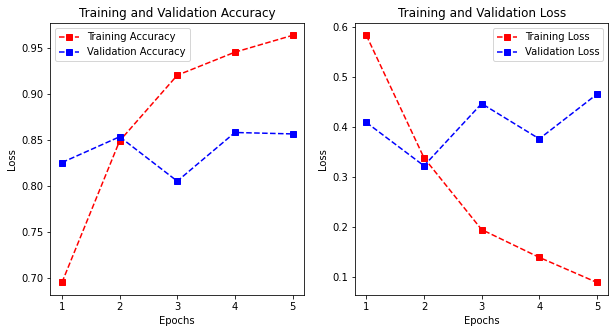

In [ ]:
plot_history(model1.history)

--------------------Accuracy Score----------------------
0.8568093385214007

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       814
           1       0.86      0.73      0.79       471

    accuracy                           0.86      1285
   macro avg       0.86      0.83      0.84      1285
weighted avg       0.86      0.86      0.85      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.074678435921669
Training Accuracy: 0.9741194844245911

-------------------Confusion Matrix---------------------


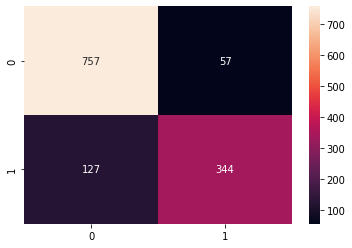

Saved model to disk


In [ ]:
model_history(model1,"bidirect_lstm_w2v")

# Model2 Embedding Bidirectional LSTM

In [ ]:
keras.backend.clear_session()
model2 = Sequential()

model2.add(Embedding(10000,
                    output_dim =DIM,
                    weights=[embedding_vectors_fast],
                    input_length = maxlen))

model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Bidirectional(LSTM(units=64, return_sequences=False)))

model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 22, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,183,425
Trainable params: 1,183,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(x_train, y_train, batch_size=64, epochs=5, verbose=True, validation_data=(x_test, y_test))

Epoch 1/5
81/81 [==============================] - 18s 123ms/step - loss: 0.5708 - acc: 0.7038 - val_loss: 0.4973 - val_acc: 0.7743
Epoch 2/5
81/81 [==============================] - 8s 100ms/step - loss: 0.3299 - acc: 0.8601 - val_loss: 0.3585 - val_acc: 0.8482
Epoch 3/5
81/81 [==============================] - 8s 100ms/step - loss: 0.2129 - acc: 0.9150 - val_loss: 0.3472 - val_acc: 0.8553
Epoch 4/5
81/81 [==============================] - 8s 98ms/step - loss: 0.1351 - acc: 0.9467 - val_loss: 0.4131 - val_acc: 0.8482
Epoch 5/5
81/81 [==============================] - 8s 100ms/step - loss: 0.0993 - acc: 0.9640 - val_loss: 0.4798 - val_acc: 0.8405


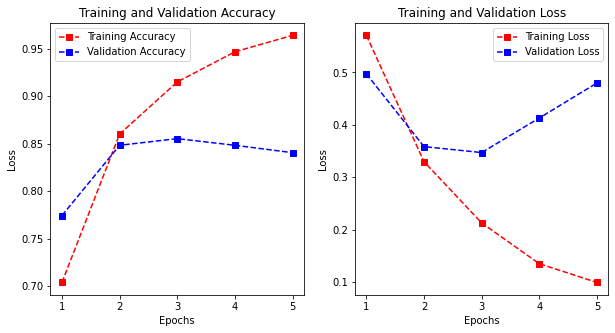

In [ ]:
plot_history(model2.history)

--------------------Accuracy Score----------------------
0.8404669260700389

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       814
           1       0.74      0.87      0.80       471

    accuracy                           0.84      1285
   macro avg       0.83      0.85      0.83      1285
weighted avg       0.85      0.84      0.84      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.07026124000549316
Training Accuracy: 0.9748978614807129

-------------------Confusion Matrix---------------------


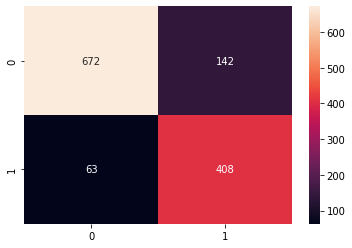

Saved model to disk


In [ ]:
model_history(model2,"bidirect_lstm_fast")

# Model3 Embedding Dense Dropout

In [ ]:
keras.backend.clear_session()
model3 = Sequential()

model3.add(Embedding(10000,
                    output_dim =DIM,
                    weights=[embedding_vectors_w2v],
                    embeddings_initializer="uniform",
                    input_length = maxlen))

model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(units=22*DIM,activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(units=500,activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 22, 100)           0         
                                                                 
 flatten (Flatten)           (None, 2200)              0         
                                                                 
 dense (Dense)               (None, 2200)              4842200   
                                                                 
 dropout_1 (Dropout)         (None, 2200)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               1100500   
                                                                 
 dropout_2 (Dropout)         (None, 500)               0

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
model3.fit(x_train, y_train, batch_size=64, epochs=10, verbose=True, validation_data=(x_test, y_test))

Epoch 1/10
81/81 [==============================] - 9s 100ms/step - loss: 0.7236 - acc: 0.5919 - val_loss: 0.6823 - val_acc: 0.5128
Epoch 2/10
81/81 [==============================] - 8s 93ms/step - loss: 0.6370 - acc: 0.6431 - val_loss: 0.5917 - val_acc: 0.6872
Epoch 3/10
81/81 [==============================] - 8s 94ms/step - loss: 0.5457 - acc: 0.7204 - val_loss: 0.4201 - val_acc: 0.8101
Epoch 4/10
81/81 [==============================] - 8s 94ms/step - loss: 0.4044 - acc: 0.8183 - val_loss: 0.3525 - val_acc: 0.8342
Epoch 5/10
81/81 [==============================] - 8s 94ms/step - loss: 0.3143 - acc: 0.8677 - val_loss: 0.3484 - val_acc: 0.8444
Epoch 6/10
81/81 [==============================] - 8s 94ms/step - loss: 0.2586 - acc: 0.8951 - val_loss: 0.3768 - val_acc: 0.8358
Epoch 7/10
81/81 [==============================] - 8s 96ms/step - loss: 0.2315 - acc: 0.9039 - val_loss: 0.3420 - val_acc: 0.8537
Epoch 8/10
81/81 [==============================] - 8s 93ms/step - loss: 0.1979 - 

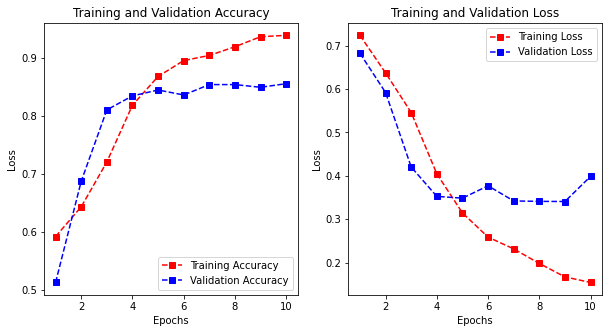

In [ ]:
plot_history(model3.history)

--------------------Accuracy Score----------------------
0.8552529182879377

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       814
           1       0.78      0.84      0.81       471

    accuracy                           0.86      1285
   macro avg       0.84      0.85      0.85      1285
weighted avg       0.86      0.86      0.86      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.07173015922307968
Training Accuracy: 0.9737303256988525

-------------------Confusion Matrix---------------------


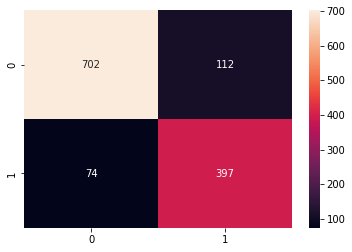

Saved model to disk


In [ ]:
model_history(model3,"dropout_w2v")

# Model4 Embedding Dense Dropout

In [ ]:
keras.backend.clear_session()
model4 = Sequential()

model4.add(Embedding(10000, #vocab_size,
                    output_dim =DIM,
                    weights=[embedding_vectors_fast], #fasttext
                    input_length = maxlen))

#LSTM 
model4.add(Dropout(0.5))
model4.add(Flatten())
model4.add(Dense(units=22*DIM,activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(units=500,activation="relu"))
model4.add(Dropout(0.5))
#model.add(LSTM(units=128))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
model4.fit(x_train, y_train, batch_size=64, epochs=5, verbose=True, validation_data=(x_test, y_test))

Epoch 1/5
81/81 [==============================] - 13s 150ms/step - loss: 0.7304 - acc: 0.5847 - val_loss: 0.6679 - val_acc: 0.5883
Epoch 2/5
81/81 [==============================] - 8s 95ms/step - loss: 0.6619 - acc: 0.6124 - val_loss: 0.6111 - val_acc: 0.6840
Epoch 3/5
81/81 [==============================] - 9s 116ms/step - loss: 0.5379 - acc: 0.7225 - val_loss: 0.3966 - val_acc: 0.8218
Epoch 4/5
81/81 [==============================] - 12s 143ms/step - loss: 0.3863 - acc: 0.8249 - val_loss: 0.3891 - val_acc: 0.8156
Epoch 5/5
81/81 [==============================] - 12s 151ms/step - loss: 0.3216 - acc: 0.8587 - val_loss: 0.3606 - val_acc: 0.8428


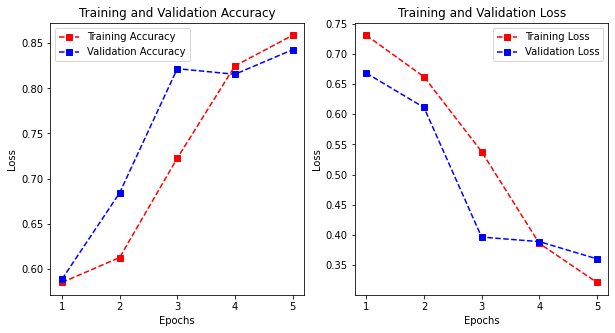

In [ ]:
plot_history(model4.history)

--------------------Accuracy Score----------------------
0.8428015564202335

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       814
           1       0.85      0.69      0.76       471

    accuracy                           0.84      1285
   macro avg       0.85      0.81      0.82      1285
weighted avg       0.84      0.84      0.84      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.22815172374248505
Training Accuracy: 0.9065966010093689

-------------------Confusion Matrix---------------------


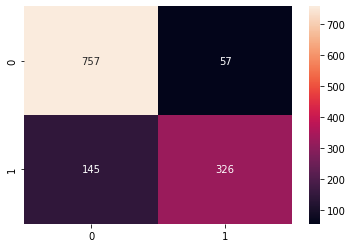

Saved model to disk


In [ ]:
model_history(model4,"dropout_fast")

# Model5 Embedding LSTM

In [ ]:
keras.backend.clear_session()
model5 = Sequential()

model5.add(Embedding(10000, #vocab_size,,
                    output_dim =DIM,
                    weights=[embedding_vectors_w2v],
                    input_length = maxlen,
                    trainable=False))


model5.add(LSTM(units=128))
model5.add(Dense(units=1, activation='sigmoid'))
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
model5.fit(x_train, y_train, batch_size=64, epochs=15, verbose=True, validation_data=(x_test, y_test))

Epoch 1/15
81/81 [==============================] - 7s 65ms/step - loss: 0.6518 - acc: 0.6359 - val_loss: 0.6281 - val_acc: 0.6817
Epoch 2/15
81/81 [==============================] - 5s 57ms/step - loss: 0.6299 - acc: 0.6517 - val_loss: 0.6006 - val_acc: 0.6949
Epoch 3/15
81/81 [==============================] - 5s 58ms/step - loss: 0.6155 - acc: 0.6680 - val_loss: 0.6019 - val_acc: 0.6856
Epoch 4/15
81/81 [==============================] - 5s 58ms/step - loss: 0.6032 - acc: 0.6822 - val_loss: 0.5823 - val_acc: 0.7043
Epoch 5/15
81/81 [==============================] - 5s 57ms/step - loss: 0.5967 - acc: 0.6900 - val_loss: 0.5774 - val_acc: 0.7089
Epoch 6/15
81/81 [==============================] - 5s 58ms/step - loss: 0.5936 - acc: 0.6943 - val_loss: 0.5760 - val_acc: 0.7051
Epoch 7/15
81/81 [==============================] - 4s 55ms/step - loss: 0.5903 - acc: 0.6964 - val_loss: 0.5728 - val_acc: 0.7105
Epoch 8/15
81/81 [==============================] - 5s 57ms/step - loss: 0.5961 - a

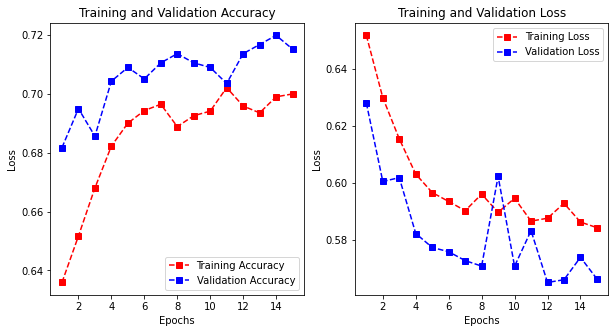

In [ ]:
plot_history(model5.history)

--------------------Accuracy Score----------------------
0.7151750972762646

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       814
           1       0.64      0.52      0.57       471

    accuracy                           0.72      1285
   macro avg       0.69      0.67      0.68      1285
weighted avg       0.71      0.72      0.71      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.5749883651733398
Training Accuracy: 0.7104495167732239

-------------------Confusion Matrix---------------------


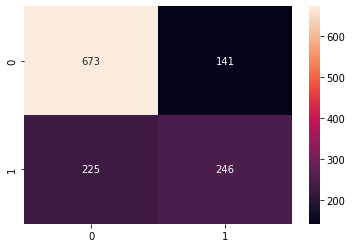

Saved model to disk


In [ ]:
model_history(model5,"lstm_w2v")

# Model6 Embedding LSTM

In [ ]:
keras.backend.clear_session()
model6 = Sequential()

model6.add(Embedding(10000, #vocab_size,,
                    output_dim =DIM,
                    weights=[embedding_vectors_fast],
                    input_length = maxlen))


model6.add(LSTM(units=128))
model6.add(Dense(units=1, activation='sigmoid'))
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model6.fit(x_train, y_train, batch_size=64, epochs=5, verbose=True, validation_data=(x_test, y_test))

Epoch 1/5
81/81 [==============================] - 10s 92ms/step - loss: 0.6084 - acc: 0.6746 - val_loss: 0.4265 - val_acc: 0.8023
Epoch 2/5
81/81 [==============================] - 6s 74ms/step - loss: 0.3548 - acc: 0.8469 - val_loss: 0.3741 - val_acc: 0.8459
Epoch 3/5
81/81 [==============================] - 6s 75ms/step - loss: 0.2330 - acc: 0.9124 - val_loss: 0.3379 - val_acc: 0.8607
Epoch 4/5
81/81 [==============================] - 6s 74ms/step - loss: 0.1618 - acc: 0.9368 - val_loss: 0.3612 - val_acc: 0.8459
Epoch 5/5
81/81 [==============================] - 6s 74ms/step - loss: 0.1079 - acc: 0.9589 - val_loss: 0.4922 - val_acc: 0.8506


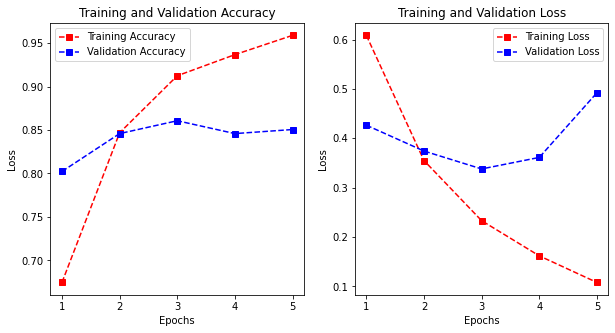

In [ ]:
plot_history(model6.history)

--------------------Accuracy Score----------------------
0.8505836575875486

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       814
           1       0.80      0.79      0.80       471

    accuracy                           0.85      1285
   macro avg       0.84      0.84      0.84      1285
weighted avg       0.85      0.85      0.85      1285


------------Training Loss Accuracy----------------------
Training Loss: 0.059890490025281906
Training Accuracy: 0.9789842367172241

-------------------Confusion Matrix---------------------


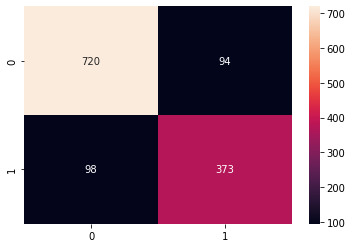

Saved model to disk


In [ ]:
model_history(model6,"lstm_fast")

# Model7 Count Vectorizer

In [ ]:
y=df['Rumour'].values
X=df['Stemmed']

In [ ]:
vectorizer = CountVectorizer()
x_count = vectorizer.fit_transform(X)
X_count = pd.DataFrame(data=x_count.toarray())
#x_count = vectorizer.transform(X_count).toarray()
x_train,x_test,y_train,y_test = train_test_split(X_count,y,test_size=0.3)

In [ ]:
keras.backend.clear_session()
input_dim = x_train.shape[1]
model7 = Sequential()
model7.add(Dense(units=1500, activation='sigmoid', input_dim=input_dim))
model7.add(Dropout(0.50))
model7.add(Dense(units=1500, activation='sigmoid'))
model7.add(Dropout(0.50))
model7.add(Dense(units=1, activation='sigmoid'))

model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              10165500  
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1501      
                                                                 
Total params: 12,418,501
Trainable params: 12,418,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model7.fit(x_train, y_train, batch_size=64, epochs=5, verbose=True, validation_data=(x_test, y_test))

Epoch 1/5
71/71 [==============================] - 10s 138ms/step - loss: 0.8950 - acc: 0.5725 - val_loss: 0.5806 - val_acc: 0.6359
Epoch 2/5
71/71 [==============================] - 10s 139ms/step - loss: 0.5317 - acc: 0.7320 - val_loss: 0.4002 - val_acc: 0.8288
Epoch 3/5
71/71 [==============================] - 10s 135ms/step - loss: 0.3653 - acc: 0.8421 - val_loss: 0.3581 - val_acc: 0.8480
Epoch 4/5
71/71 [==============================] - 9s 133ms/step - loss: 0.2917 - acc: 0.8786 - val_loss: 0.3440 - val_acc: 0.8532
Epoch 5/5
71/71 [==============================] - 10s 137ms/step - loss: 0.2571 - acc: 0.8964 - val_loss: 0.3438 - val_acc: 0.8548


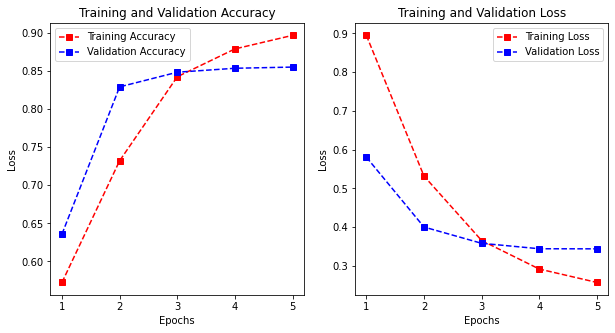

In [ ]:
plot_history(model7.history)

--------------------Accuracy Score----------------------
0.8547717842323651

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1191
           1       0.82      0.79      0.81       737

    accuracy                           0.85      1928
   macro avg       0.85      0.84      0.85      1928
weighted avg       0.85      0.85      0.85      1928


------------Training Loss Accuracy----------------------
Training Loss: 0.16667847335338593
Training Accuracy: 0.940391480922699

-------------------Confusion Matrix---------------------


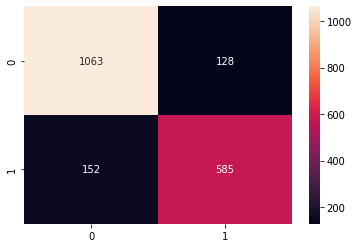

Saved model to disk


In [ ]:
model_history(model7,"count_vec")

# Model8 Hashing Vectorizer

In [ ]:
text =df.Stemmed
vectorizer = HashingVectorizer(n_features=22)
vector = vectorizer.transform(text)
X_count = pd.DataFrame(data=vector.toarray())
x_train,x_test,y_train,y_test = train_test_split(X_count,y)

In [ ]:
keras.backend.clear_session()
model8 = Sequential()

model8 = Sequential()
model8.add(Dense(units=1500, activation='sigmoid', input_dim=22))
model8.add(Dropout(0.50))
model8.add(Dense(units=1500, activation='sigmoid'))
model8.add(Dropout(0.50))
model8.add(Dense(units=1, activation='sigmoid'))

model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              34500     
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1501      
                                                                 
Total params: 2,287,501
Trainable params: 2,287,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model8.fit(x_train, y_train, batch_size=64, epochs=20, verbose=True, validation_data=(x_test, y_test))

Epoch 1/20
76/76 [==============================] - 4s 46ms/step - loss: 0.8598 - acc: 0.5677 - val_loss: 0.6652 - val_acc: 0.6171
Epoch 2/20
76/76 [==============================] - 3s 42ms/step - loss: 0.7249 - acc: 0.5691 - val_loss: 0.6786 - val_acc: 0.6171
Epoch 3/20
76/76 [==============================] - 3s 42ms/step - loss: 0.6998 - acc: 0.5928 - val_loss: 0.6618 - val_acc: 0.6171
Epoch 4/20
76/76 [==============================] - 3s 42ms/step - loss: 0.6847 - acc: 0.5986 - val_loss: 0.6646 - val_acc: 0.6171
Epoch 5/20
76/76 [==============================] - 3s 44ms/step - loss: 0.6695 - acc: 0.6162 - val_loss: 0.6505 - val_acc: 0.6171
Epoch 6/20
76/76 [==============================] - 4s 55ms/step - loss: 0.6653 - acc: 0.6125 - val_loss: 0.6492 - val_acc: 0.6171
Epoch 7/20
76/76 [==============================] - 3s 43ms/step - loss: 0.6506 - acc: 0.6274 - val_loss: 0.6442 - val_acc: 0.6171
Epoch 8/20
76/76 [==============================] - 3s 43ms/step - loss: 0.6638 - a

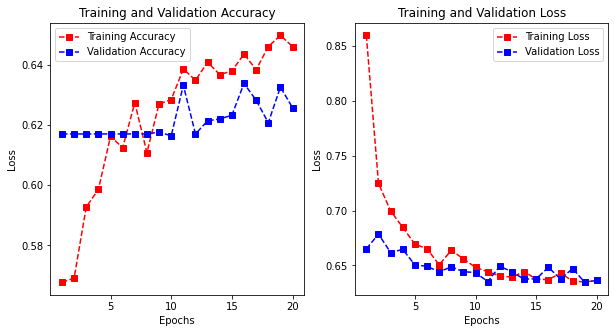

In [ ]:
plot_history(model8.history)

--------------------Accuracy Score----------------------
0.6257783312577833

----------------Classification Report ------------------
              precision    recall  f1-score   support

           0       0.63      0.94      0.76       991
           1       0.55      0.12      0.20       615

    accuracy                           0.63      1606
   macro avg       0.59      0.53      0.48      1606
weighted avg       0.60      0.63      0.54      1606


------------Training Loss Accuracy----------------------
Training Loss: 0.6241155862808228
Training Accuracy: 0.6500622630119324

-------------------Confusion Matrix---------------------


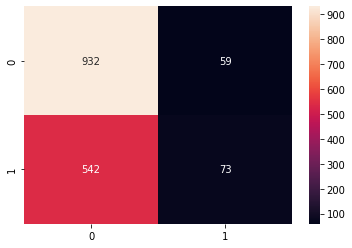

Saved model to disk


In [ ]:
model_history(model8,"hash_vec")

# Sonuçlar

In [ ]:
scores

[['bidirect_lstm_w2v', 0.974, 0.075, 0.857],
 ['bidirect_lstm_fast', 0.975, 0.07, 0.84],
 ['dropout_w2v', 0.974, 0.072, 0.855],
 ['dropout_fast', 0.907, 0.228, 0.843],
 ['lstm_w2v', 0.71, 0.575, 0.715],
 ['lstm_fast', 0.979, 0.06, 0.851],
 ['count_vec', 0.94, 0.167, 0.855],
 ['hash_vec', 0.65, 0.624, 0.626]]

In [ ]:
scores = pd.DataFrame(scores)

In [ ]:
scores.columns = ["Name","Acc","Loss","Val_Acc"]

In [ ]:
scores.sort_values("Acc",ascending=False)

,Name,Acc,Loss,Val_Acc
5,lstm_fast,0.979,0.060,0.851
1,bidirect_lstm_fast,0.975,0.070,0.840
0,bidirect_lstm_w2v,0.974,0.075,0.857
2,dropout_w2v,0.974,0.072,0.855
6,count_vec,0.940,0.167,0.855
3,dropout_fast,0.907,0.228,0.843
4,lstm_w2v,0.710,0.575,0.715
7,hash_vec,0.650,0.624,0.626


In [ ]:
scores.sort_values("Val_Acc",ascending=False)

,Name,Acc,Loss,Val_Acc
0,bidirect_lstm_w2v,0.974,0.075,0.857
2,dropout_w2v,0.974,0.072,0.855
6,count_vec,0.940,0.167,0.855
5,lstm_fast,0.979,0.060,0.851
3,dropout_fast,0.907,0.228,0.843
1,bidirect_lstm_fast,0.975,0.070,0.840
4,lstm_w2v,0.710,0.575,0.715
7,hash_vec,0.650,0.624,0.626
